In [1]:
%pip install -qq -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets_tourism import *

> 2024-06-12 08:53:37,590 [info] Project loaded successfully: {'project_name': 'overtourism'}


## Setup dataset

In [3]:
START_DATE = "2023-07-01"
END_DATE= "2023-08-31"

In [4]:
statistiche_parcheggi_molveno_df["date"] = pd.to_datetime(statistiche_parcheggi_molveno_df["date"])

In [5]:
contamezzi_df.rename(columns={"data": "date"}, inplace=True)
contamezzi_df["date"] = pd.to_datetime(contamezzi_df["date"])
contamezzi_df["day"] = pd.to_datetime(pd.to_datetime(contamezzi_df["date"]).dt.date)
contamezzi_df["hour"] = pd.to_datetime(contamezzi_df["date"]).dt.hour
contamezzi_df = contamezzi_df[
    (contamezzi_df["date"] >= START_DATE) &
    (contamezzi_df["date"] <= END_DATE)
]
contamezzi_df["total_cars"] = contamezzi_df[["cl1", "cl2", "cl3", "cl4", "cl5", "cl6", "cl7", "nonrilevato"]].sum(axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Contamezzi spiaggia

In [6]:
DRIFT_CORRECTION_FACTOR = 1.075

entrata_lago = contamezzi_df[(contamezzi_df["sensore"] == "M47") & (contamezzi_df["direzione"] == 1) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
entrata_lago = entrata_lago.reset_index().drop(columns=['index','sensore','direzione','comune'])

uscita_lago = contamezzi_df[(contamezzi_df["sensore"] == "M47") & (contamezzi_df["direzione"] == 2) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
uscita_lago = uscita_lago.reset_index().drop(columns=['index','sensore','direzione','comune'])

differenza_lago = entrata_lago.set_index(['date','day','hour']).subtract(uscita_lago.set_index(['date','day','hour'])*DRIFT_CORRECTION_FACTOR, fill_value=0).reset_index()

cumulativa_lago = differenza_lago.copy()
for c in ['cl1','cl2','cl3','cl4','cl5','cl6','cl7','nonrilevato','total_cars']: 
    cumulativa_lago[c] = cumulativa_lago[c].cumsum()
cumulativa_lago

,date,day,hour,cl1,cl2,cl3,cl4,cl5,cl6,cl7,nonrilevato,total_cars
0,2023-07-01 00:00:00,2023-07-01,0,5.775,-1.075,0.000,0.000,0.0,0.000,0.0,0.0,4.700
1,2023-07-01 01:00:00,2023-07-01,1,6.550,-1.075,0.000,0.000,0.0,0.000,0.0,0.0,5.475
2,2023-07-01 02:00:00,2023-07-01,2,6.400,-1.075,0.000,0.000,0.0,0.000,0.0,0.0,5.325
3,2023-07-01 03:00:00,2023-07-01,3,6.400,-0.075,0.000,0.000,0.0,0.000,0.0,0.0,6.325
4,2023-07-01 04:00:00,2023-07-01,4,8.400,0.925,0.000,0.000,0.0,0.000,0.0,0.0,9.325
...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2023-08-30 20:00:00,2023-08-30,20,3791.325,320.175,-375.825,502.025,847.9,-76.475,-46.7,-3256.5,1705.925
1461,2023-08-30 21:00:00,2023-08-30,21,3766.550,320.950,-374.825,500.950,847.9,-76.475,-46.7,-3256.5,1681.850
1462,2023-08-30 22:00:00,2023-08-30,22,3760.825,321.800,-374.825,500.950,847.9,-76.475,-46.7,-3255.5,1677.975
1463,2023-08-30 23:00:00,2023-08-30,23,3751.550,321.725,-374.825,501.950,847.9,-76.475,-46.7,-3255.5,1669.625


In [7]:
cumulativa_lago_day = cumulativa_lago.groupby("day")["total_cars"].max()
cumulativa_lago_day = pd.DataFrame(pd.Series(cumulativa_lago_day)).reset_index().rename(columns={'day':'date'})
cumulativa_lago_day

,date,total_cars
0,2023-07-01,210.900
1,2023-07-02,739.675
2,2023-07-03,174.725
3,2023-07-04,78.250
4,2023-07-05,64.750
...,...,...
57,2023-08-27,1887.725
58,2023-08-28,1668.375
59,2023-08-29,1627.725
60,2023-08-30,1737.300


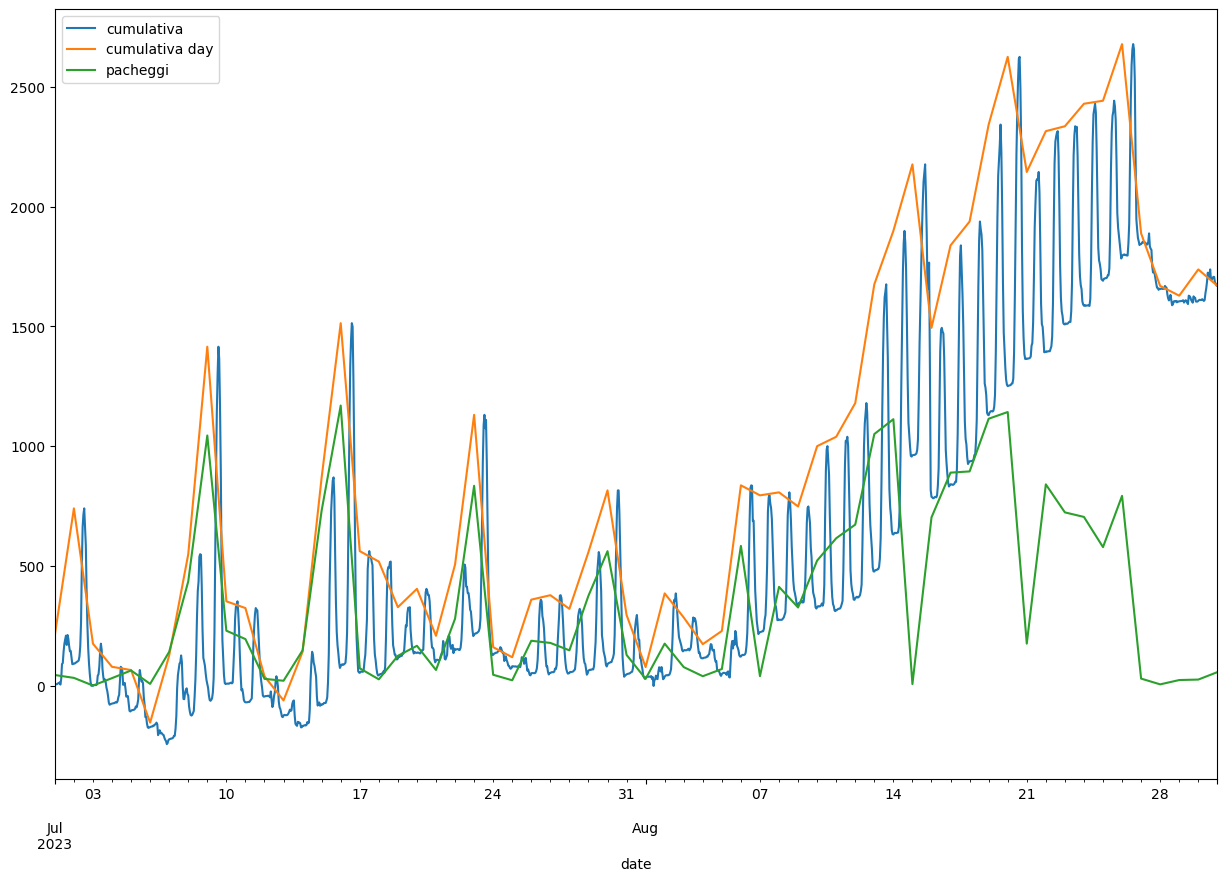

In [8]:
ax = None
#ax = entrata_lago.plot(ax=ax, x="date", y="total_cars", label="entrata", figsize=(15,10))
#ax = uscita_lago.plot(ax=ax, x="date", y="total_cars", label="uscita", figsize=(15,10))
#ax = differenza_lago.plot(ax=ax, x="date", y="total_cars", label="diff", figsize=(15,10))
ax = cumulativa_lago.plot(ax=ax, x="date", y="total_cars", label="cumulativa", figsize=(15,10))

ax = cumulativa_lago_day.plot(ax=ax, x="date", y="total_cars", label="cumulativa day", figsize=(15,10))

ax = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].plot(ax=ax, x="date", y="TOTALE", label="pacheggi", figsize=(15,10))

## Contamezzi Molveno

In [9]:
DRIFT_CORRECTION_FACTOR = 1.09

entrata_paese_1 = contamezzi_df[(contamezzi_df["sensore"] == "M40") & (contamezzi_df["direzione"] == 1) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
entrata_paese_1 = entrata_paese_1.reset_index().drop(columns=['index','sensore','direzione','comune'])

uscita_paese_1 = contamezzi_df[(contamezzi_df["sensore"] == "M40") & (contamezzi_df["direzione"] == 2) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
uscita_paese_1 = uscita_paese_1.reset_index().drop(columns=['index','sensore','direzione','comune'])

entrata_paese_2 = contamezzi_df[(contamezzi_df["sensore"] == "M42") & (contamezzi_df["direzione"] == 1) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
entrata_paese_2 = entrata_paese_2.reset_index().drop(columns=['index','sensore','direzione','comune'])

uscita_paese_2 = contamezzi_df[(contamezzi_df["sensore"] == "M42") & (contamezzi_df["direzione"] == 2) & (contamezzi_df["day"] >= START_DATE) & (contamezzi_df["day"] <= END_DATE)]
uscita_paese_2 = uscita_paese_2.reset_index().drop(columns=['index','sensore','direzione','comune'])

entrata_paese = entrata_paese_1.set_index(['date','day','hour']).add(entrata_paese_2.set_index(['date','day','hour']), fill_value=0).reset_index()
uscita_paese = uscita_paese_1.set_index(['date','day','hour']).add(uscita_paese_2.set_index(['date','day','hour']), fill_value=0).reset_index()

differenza_paese = entrata_paese.set_index(['date','day','hour']).subtract(uscita_paese.set_index(['date','day','hour'])*DRIFT_CORRECTION_FACTOR, fill_value=0).reset_index()

cumulativa_paese = differenza_paese.copy()
for c in ['cl1','cl2','cl3','cl4','cl5','cl6','cl7','nonrilevato','total_cars']: 
    cumulativa_paese[c] = cumulativa_paese[c].cumsum()
cumulativa_paese

,date,day,hour,cl1,cl2,cl3,cl4,cl5,cl6,cl7,nonrilevato,total_cars
0,2023-07-01 00:00:00,2023-07-01,0,-0.62,3.82,0.00,1.0,0.0,0.00,0.00,0.00,4.20
1,2023-07-01 01:00:00,2023-07-01,1,8.20,2.73,1.00,1.0,0.0,0.00,0.00,1.00,13.93
2,2023-07-01 02:00:00,2023-07-01,2,12.02,1.64,1.00,1.0,0.0,0.00,0.00,1.00,16.66
3,2023-07-01 03:00:00,2023-07-01,3,10.93,1.64,2.00,1.0,0.0,0.00,0.00,1.00,16.57
4,2023-07-01 04:00:00,2023-07-01,4,6.21,4.64,2.00,2.0,0.0,0.00,0.00,1.00,15.85
...,...,...,...,...,...,...,...,...,...,...,...,...
1460,2023-08-30 20:00:00,2023-08-30,20,-27087.80,14638.60,5988.92,3279.5,428.2,219.16,-111.97,2313.40,-331.99
1461,2023-08-30 21:00:00,2023-08-30,21,-27087.75,14642.51,5988.92,3280.5,429.2,220.16,-111.97,2317.31,-321.12
1462,2023-08-30 22:00:00,2023-08-30,22,-27062.35,14642.06,5987.83,3281.5,429.2,219.07,-111.97,2320.31,-294.35
1463,2023-08-30 23:00:00,2023-08-30,23,-27059.78,14644.06,5988.83,3282.5,429.2,219.07,-111.97,2320.31,-287.78


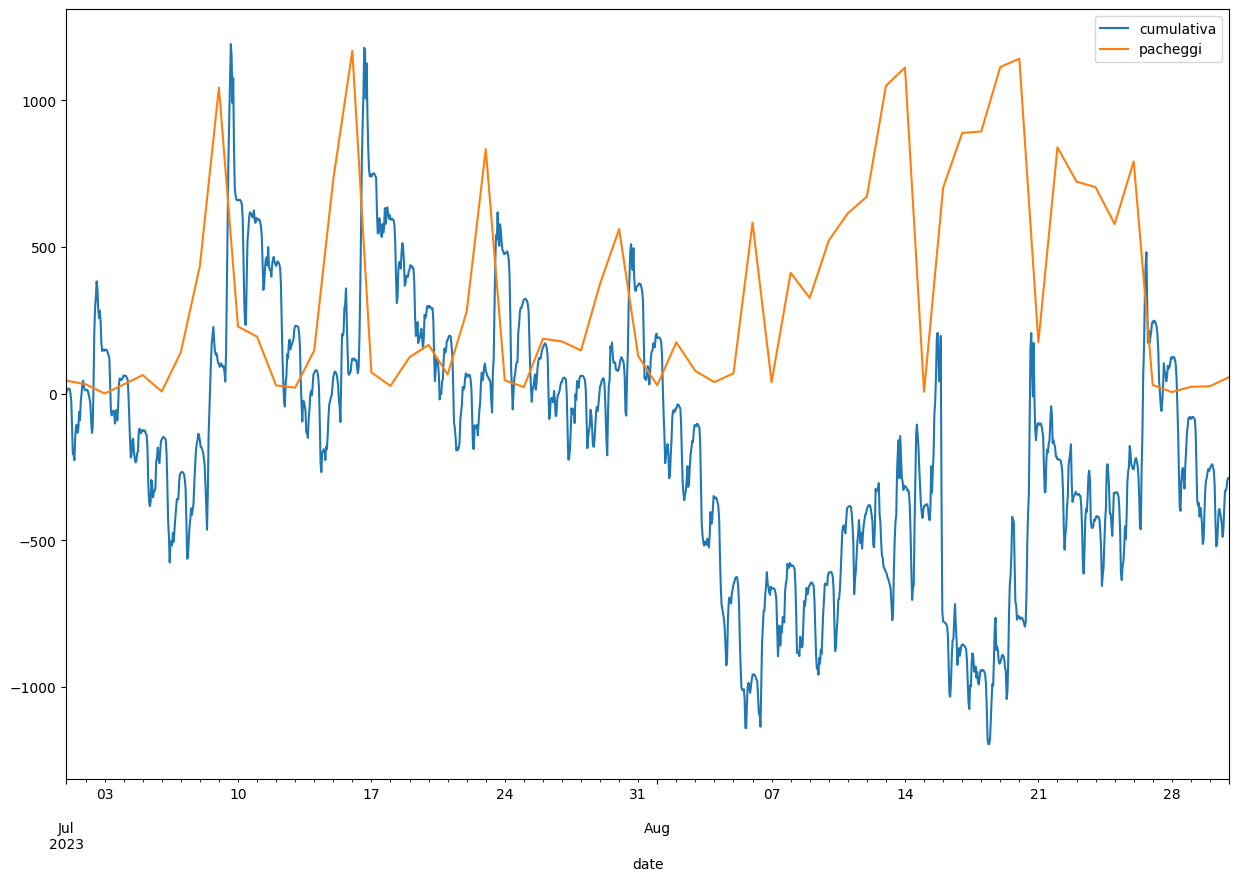

In [10]:
ax = None
#ax = entrata_paese.plot(ax=ax, x="date", y="total_cars", label="entrata", figsize=(15,10))
#ax = uscita_paese.plot(ax=ax, x="date", y="total_cars", label="uscita", figsize=(15,10))
#ax = differenza_paese.plot(ax=ax, x="date", y="total_cars", label="diff", figsize=(15,10))
ax = cumulativa_paese.plot(ax=ax, x="date", y="total_cars", label="cumulativa", figsize=(15,10))

ax = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].plot(ax=ax, x="date", y="TOTALE", label="pacheggi", figsize=(15,10))


## Presenze in spiaggia

In [11]:
contapersone_presenze_df.rename(columns={"data": "date"}, inplace=True)
contapersone_presenze_df["date"] = pd.to_datetime(contapersone_presenze_df["date"])

contapersone_presenze_df = contapersone_presenze_df[(contapersone_presenze_df['date'] >= START_DATE) & (contapersone_presenze_df['date'] <= END_DATE)] 
contapersone_presenze_df

,date,varco,presenze
0,2023-07-15,Varco 1,183
1,2023-07-15,Varco 2,204
2,2023-07-15,Varco 3,304
3,2023-07-15,Varco 4,199
4,2023-07-15,Varco 5,117
...,...,...,...
427,2023-08-31,Varco 5,127
428,2023-08-31,Varco 6,145
429,2023-08-31,Varco 7,267
430,2023-08-31,Varco 8,145


In [12]:
varchi = contapersone_presenze_df['varco'].unique()
varchi

array(['Varco 1', 'Varco 2', 'Varco 3', 'Varco 4', 'Varco 5', 'Varco 6',
       'Varco 7', 'Varco 8', 'Varco 9'], dtype=object)

In [13]:
contapersone = contapersone_presenze_df.copy()
for v in varchi:
    contapersone[v] = contapersone['presenze'] * (contapersone['varco'] == v)
contapersone

,date,varco,presenze,Varco 1,Varco 2,Varco 3,Varco 4,Varco 5,Varco 6,Varco 7,Varco 8,Varco 9
0,2023-07-15,Varco 1,183,183,0,0,0,0,0,0,0,0
1,2023-07-15,Varco 2,204,0,204,0,0,0,0,0,0,0
2,2023-07-15,Varco 3,304,0,0,304,0,0,0,0,0,0
3,2023-07-15,Varco 4,199,0,0,0,199,0,0,0,0,0
4,2023-07-15,Varco 5,117,0,0,0,0,117,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
427,2023-08-31,Varco 5,127,0,0,0,0,127,0,0,0,0
428,2023-08-31,Varco 6,145,0,0,0,0,0,145,0,0,0
429,2023-08-31,Varco 7,267,0,0,0,0,0,0,267,0,0
430,2023-08-31,Varco 8,145,0,0,0,0,0,0,0,145,0


In [14]:
contapersone = contapersone.drop(columns=['varco']).groupby('date').sum().reset_index().rename(columns={'presenze':'contapersone'})
contapersone

,date,contapersone,Varco 1,Varco 2,Varco 3,Varco 4,Varco 5,Varco 6,Varco 7,Varco 8,Varco 9
0,2023-07-15,1496,183,204,304,199,117,83,161,105,140
1,2023-07-16,2143,299,305,340,321,157,137,228,106,250
2,2023-07-17,1663,175,262,307,144,135,77,140,64,359
3,2023-07-18,1518,129,300,280,152,117,83,146,73,238
4,2023-07-19,1345,111,153,309,109,130,65,137,55,276
5,2023-07-20,1337,134,261,266,139,134,66,122,66,149
6,2023-07-21,982,86,130,223,92,85,51,134,49,132
7,2023-07-22,1396,131,187,293,178,119,87,171,71,159
8,2023-07-23,2021,290,279,437,216,102,115,261,118,203
9,2023-07-24,746,44,73,162,80,54,36,101,43,153


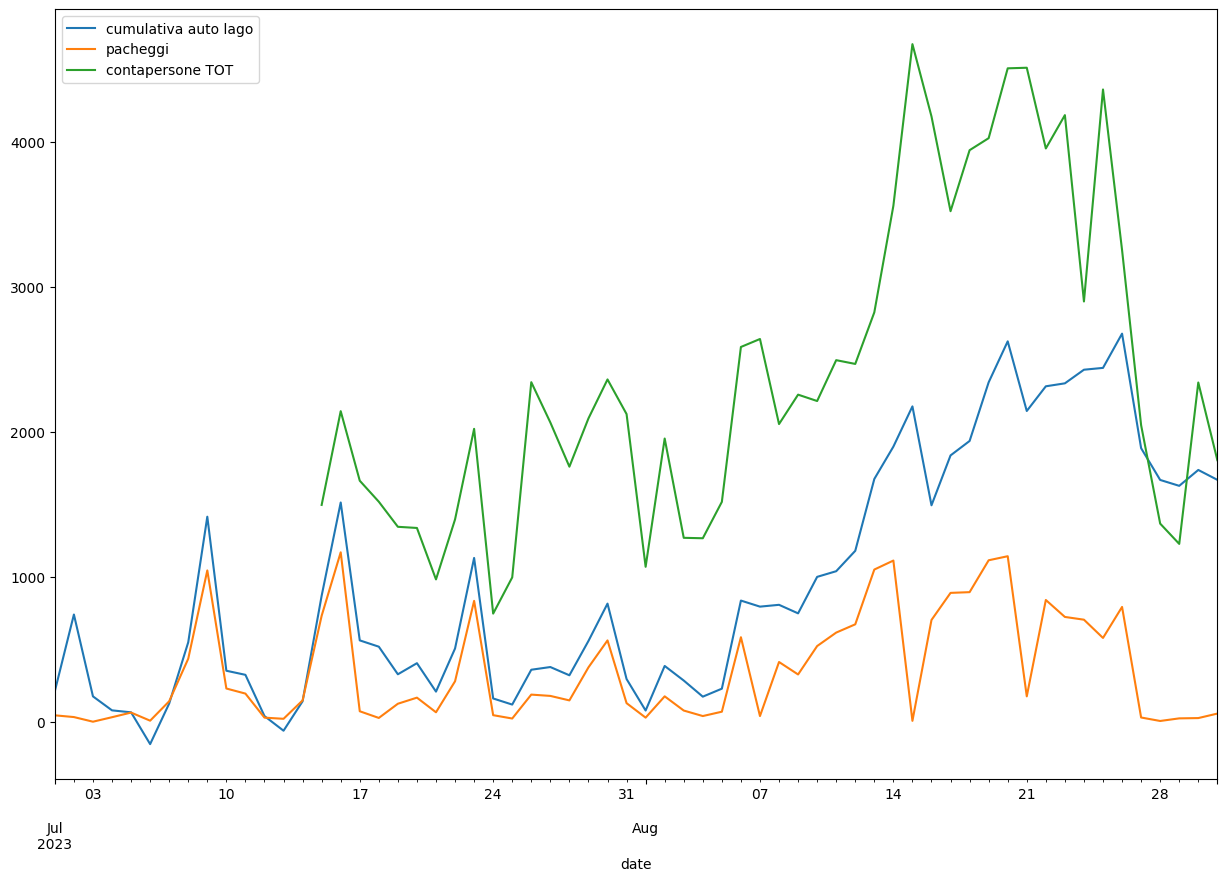

In [15]:
ax = None
ax = cumulativa_lago_day.plot(ax=ax, x="date", y="total_cars", label="cumulativa auto lago", figsize=(15,10))
ax = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].plot(ax=ax, x="date", y="TOTALE", label="pacheggi", figsize=(15,10))

ax = contapersone.plot(ax=ax, x="date", y="contapersone", label="contapersone TOT", figsize=(15,10))
#ax = contapersone.plot(ax=ax, x="date", y="Varco 1", label="contapersone V1", figsize=(15,10))
#ax = contapersone.plot(ax=ax, x="date", y="Varco 8", label="contapersone V8", figsize=(15,10))


## Movimenti

In [16]:
movimento_turistico_molveno_df.rename(columns={"giorno": "date"}, inplace=True)
presenze_turistiche = movimento_turistico_molveno_df.copy()[['date','presenze']]
presenze_turistiche = presenze_turistiche[(presenze_turistiche['date'] >= START_DATE) & (presenze_turistiche['date'] <= END_DATE)]
presenze_turistiche

,date,presenze
546,2023-07-01,2422
547,2023-07-02,2307
548,2023-07-03,2521
549,2023-07-04,2599
550,2023-07-05,2668
...,...,...
603,2023-08-27,2370
604,2023-08-28,2420
605,2023-08-29,2463
606,2023-08-30,2584


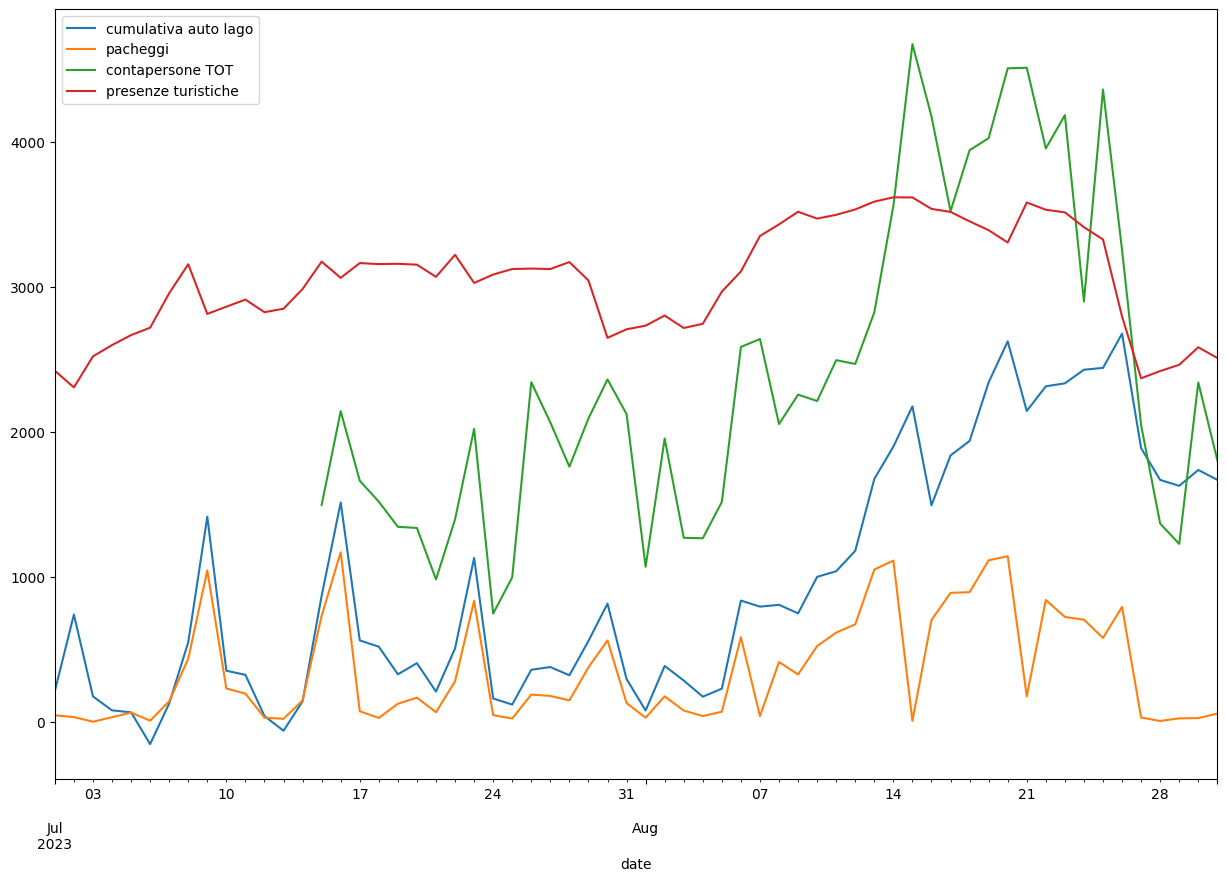

In [17]:
ax = None
ax = cumulativa_lago_day.plot(ax=ax, x="date", y="total_cars", label="cumulativa auto lago", figsize=(15,10))
ax = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].plot(ax=ax, x="date", y="TOTALE", label="pacheggi", figsize=(15,10))

ax = contapersone.plot(ax=ax, x="date", y="contapersone", label="contapersone TOT", figsize=(15,10))

ax = presenze_turistiche.plot(ax=ax, x="date", y="presenze", label="presenze turistiche", figsize=(15,10))

## Dati Vodafone

In [18]:
vodafone_attendences_df["date"] = pd.to_datetime(vodafone_attendences_df["date"])

LOC_ID_LAGO_MOLVENO = "LAGO_MOLV"
LOC_ID_MOLVENO = "27"
LOC_ID_APT_MOLVENO = "105"

presenze_vodafone = vodafone_attendences_df[
    (vodafone_attendences_df["date"] >= START_DATE) &
    (vodafone_attendences_df["date"] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    #(vodafone_attendences_df["userProfile"] == "TOURIST") &
    (vodafone_attendences_df["locId"] == LOC_ID_MOLVENO)
]
presenze_vodafone

,date,locType,locId,userCountry,userProfile,userCluster,value
201689,2023-07-01,TN_MKT_AL_3,27,STR,TOURIST,STR,735
201690,2023-07-01,TN_MKT_AL_3,27,STR,VISITOR,STR,360
202071,2023-07-02,TN_MKT_AL_3,27,STR,COMMUTER,STR,24
202072,2023-07-02,TN_MKT_AL_3,27,STR,TOURIST,STR,731
202073,2023-07-02,TN_MKT_AL_3,27,STR,VISITOR,STR,523
...,...,...,...,...,...,...,...
225134,2023-08-29,TN_MKT_AL_3,27,STR,VISITOR,STR,383
225527,2023-08-30,TN_MKT_AL_3,27,STR,TOURIST,STR,881
225528,2023-08-30,TN_MKT_AL_3,27,STR,VISITOR,STR,421
225917,2023-08-31,TN_MKT_AL_3,27,STR,TOURIST,STR,887


In [19]:
presenze_vodafone = presenze_vodafone.drop(columns=['locType','locId','userCountry','userProfile','userCluster']).groupby('date').sum().reset_index().rename(columns={'value':'vodafone'})
presenze_vodafone

,date,vodafone
0,2023-07-01,1095
1,2023-07-02,1278
2,2023-07-03,1186
3,2023-07-04,1116
4,2023-07-05,1391
...,...,...
57,2023-08-27,1211
58,2023-08-28,899
59,2023-08-29,1157
60,2023-08-30,1302


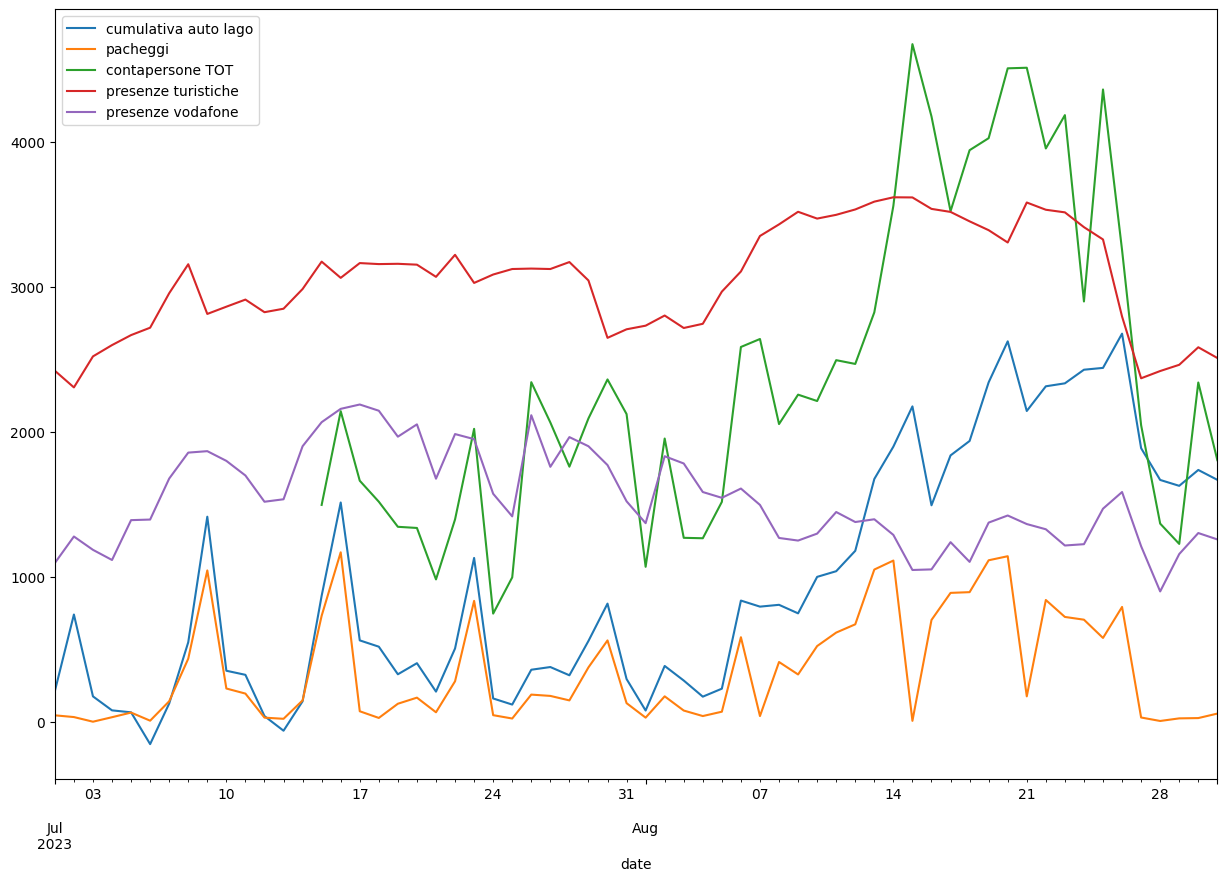

In [20]:
ax = None
ax = cumulativa_lago_day.plot(ax=ax, x="date", y="total_cars", label="cumulativa auto lago", figsize=(15,10))
ax = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].plot(ax=ax, x="date", y="TOTALE", label="pacheggi", figsize=(15,10))

ax = contapersone.plot(ax=ax, x="date", y="contapersone", label="contapersone TOT", figsize=(15,10))

ax = presenze_turistiche.plot(ax=ax, x="date", y="presenze", label="presenze turistiche", figsize=(15,10))

ax = presenze_vodafone.plot(ax=ax, x="date", y="vodafone", label="presenze vodafone", figsize=(15,10))

## Correlazione

In [21]:
parcheggi = statistiche_parcheggi_molveno_df[(statistiche_parcheggi_molveno_df["date"] >= START_DATE) & (statistiche_parcheggi_molveno_df["date"] <= END_DATE)].set_index('date')[['TOTALE']].rename(columns={'TOTALE':'parcheggi'})

all = pd.concat([cumulativa_lago_day.set_index('date'),
                 parcheggi,
                 presenze_turistiche.set_index('date'),
                 presenze_vodafone.set_index('date'),
                 contapersone.set_index('date'),
                ], axis=1)
all

,total_cars,parcheggi,presenze,vodafone,contapersone,Varco 1,Varco 2,Varco 3,Varco 4,Varco 5,Varco 6,Varco 7,Varco 8,Varco 9
date,,,,,,,,,,,,,,
2023-07-01,210.900,44.0,2422,1095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-02,739.675,32.0,2307,1278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-03,174.725,0.0,2521,1186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-04,78.250,31.0,2599,1116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-05,64.750,63.0,2668,1391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-27,1887.725,29.0,2370,1211,2046.0,55.0,83.0,363.0,386.0,136.0,181.0,354.0,163.0,325.0
2023-08-28,1668.375,5.0,2420,899,1367.0,48.0,65.0,168.0,192.0,68.0,95.0,217.0,95.0,419.0
2023-08-29,1627.725,23.0,2463,1157,1227.0,46.0,97.0,144.0,174.0,82.0,116.0,206.0,98.0,264.0


In [22]:
correlations = all.corr()
correlations.style.background_gradient(cmap ='coolwarm') 

,total_cars,parcheggi,presenze,vodafone,contapersone,Varco 1,Varco 2,Varco 3,Varco 4,Varco 5,Varco 6,Varco 7,Varco 8,Varco 9
total_cars,1.000000,0.642129,0.386460,-0.392850,0.800069,0.661102,0.394774,0.258169,0.800133,0.454755,0.806588,0.782228,0.814602,0.613177
parcheggi,0.642129,1.000000,0.548372,0.005384,0.595733,0.792887,0.569862,0.512165,0.571426,0.249585,0.556971,0.528666,0.569679,0.348705
presenze,0.386460,0.548372,1.000000,0.015231,0.584902,0.659153,0.698517,0.500735,0.481795,0.004311,0.514121,0.523238,0.516257,0.481692
vodafone,-0.392850,0.005384,0.015231,1.000000,-0.447172,-0.077683,0.075353,-0.000295,-0.469822,0.031067,-0.519995,-0.521253,-0.517475,-0.483363
contapersone,0.800069,0.595733,0.584902,-0.447172,1.000000,0.772932,0.694441,0.540424,0.930150,0.317491,0.959712,0.968671,0.958433,0.840152
Varco 1,0.661102,0.792887,0.659153,-0.077683,0.772932,1.000000,0.780457,0.533621,0.731183,0.348676,0.716583,0.688676,0.717686,0.486327
Varco 2,0.394774,0.569862,0.698517,0.075353,0.694441,0.780457,1.000000,0.586357,0.615979,0.134367,0.599094,0.595079,0.607047,0.491094
Varco 3,0.258169,0.512165,0.500735,-0.000295,0.540424,0.533621,0.586357,1.000000,0.432085,0.079142,0.438169,0.443703,0.425518,0.395624
Varco 4,0.800133,0.571426,0.481795,-0.469822,0.930150,0.731183,0.615979,0.432085,1.000000,0.267432,0.973158,0.934687,0.982234,0.641980
Varco 5,0.454755,0.249585,0.004311,0.031067,0.317491,0.348676,0.134367,0.079142,0.267432,1.000000,0.251356,0.284412,0.278782,0.086708


In [23]:
# TODO:
# - calcolare e modellare rapporto delta presense / veicoli
# - tenere conto di diverse tipologie di veicoli
# - gestire meglio il drift dei contaveicoli

In [24]:
# DOMANDE:
# - dove sono i varchi?
# - tipi di veicoli?
# - vodafone: semantica
# - parcheggi e capienza